I am practicing on what Kandrani has made for feature extractions.
I found that he is normalizing some values and leaving some values.
for example:
`avg_lane_angle` could be normalized by dividing it by pi
```python
avg_lane_angle/np.pi
```
the `speed` could also be normalized. After running some tests to find the maximum speed, I got the highest value of `98.5061956708646` as speed. So I am going to assume the maximum speed is 100. For safety we are going to take the minium in case the speed could be higher (1.02), it will be maxed to 1.
```python
min(speed/100.0,1.0)
```

[Episode 1] Total reward: -44.83
[Episode 2] Total reward: -49.39
[Episode 3] Total reward: -82.18
[Episode 4] Total reward: -24.82
[Episode 5] Total reward: -57.84
[Episode 6] Total reward: -26.97
[Episode 7] Total reward: 42.07
[Episode 8] Total reward: -3.78
[Episode 9] Total reward: -59.63
[Episode 10] Total reward: -7.86
[Episode 11] Total reward: -41.62
[Episode 12] Total reward: -38.04
[Episode 13] Total reward: -51.23
[Episode 14] Total reward: -30.15
[Episode 15] Total reward: -30.06
[Episode 16] Total reward: -28.33
[Episode 17] Total reward: -23.57
[Episode 18] Total reward: -30.71
[Episode 19] Total reward: -32.04
[Episode 20] Total reward: -50.13
[Episode 21] Total reward: -48.57
[Episode 22] Total reward: -18.57
[Episode 23] Total reward: -61.20
[Episode 24] Total reward: -64.39
[Episode 25] Total reward: 14.55
[Episode 26] Total reward: -16.50
[Episode 27] Total reward: -13.37
[Episode 28] Total reward: -39.06
[Episode 29] Total reward: -75.39
[Episode 30] Total reward: 

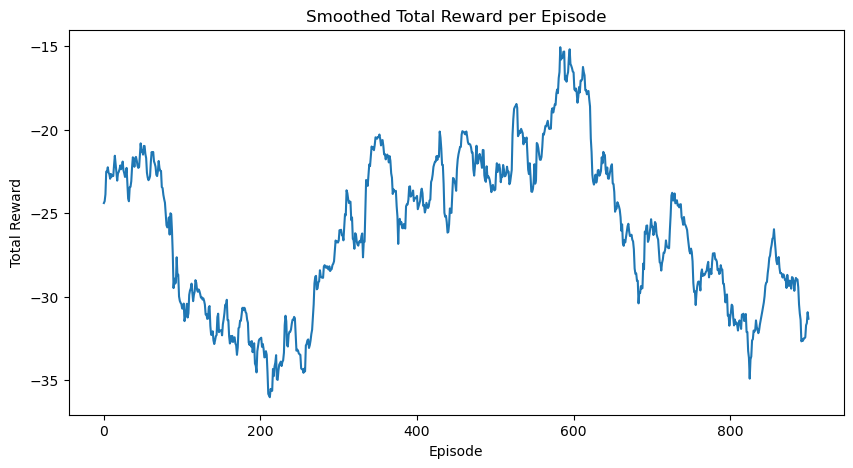

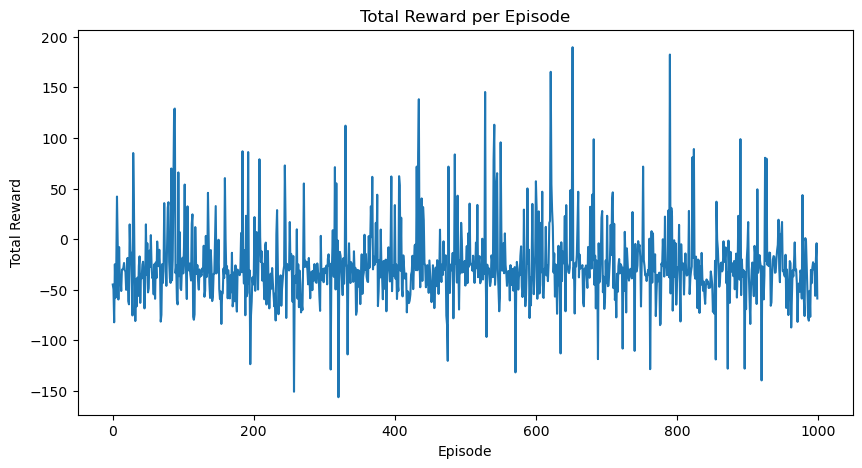

In [5]:
import gymnasium as gym
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt
import os

# --- ENV + RL CONFIG ---
CROP_HEIGHT_PERCENTAGE = 0.12
DO_NOTHING, LEFT, RIGHT, GAS, BRAKE = 0, 1, 2, 3, 4
record_episodes = {10, 100, 1000, 1700, 2000, 2500}
n_actions = 5
feature_dim = 5

# --- TILE CODER CLASS ---
class TileCoder:
    def __init__(self, num_tilings, tiles_per_dim, input_dim, n_actions, low, high):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.input_dim = input_dim
        self.n_actions = n_actions
        self.low = np.array(low)
        self.high = np.array(high)
        self.tile_width = (self.high - self.low) / (tiles_per_dim - 1)
        self.total_tiles_per_tiling = tiles_per_dim ** input_dim
        self.total_features = self.total_tiles_per_tiling * num_tilings * n_actions
        self.offsets = np.stack([np.linspace(0, w, num_tilings, endpoint=False) for w in self.tile_width], axis=1)

    def get_features(self, state, action):
        state = np.array(state)
        features = np.zeros(self.total_features, dtype=np.float32)
        for tiling in range(self.num_tilings):
            offset = self.offsets[tiling]
            shifted = state + offset
            indices = ((shifted - self.low) / self.tile_width).astype(int)
            indices = np.clip(indices, 0, self.tiles_per_dim - 1)
            tile_index = sum(indices[i] * (self.tiles_per_dim ** (self.input_dim - i - 1)) for i in range(self.input_dim))
            index = tiling * self.total_tiles_per_tiling * self.n_actions + tile_index * self.n_actions + action
            features[index] = 1.0
        return features

# --- FEATURE EXTRACTION ---
def extract_features(obs, obs_history, speed_history, env):
    vel_vec = env.unwrapped.car.hull.linearVelocity
    speed = np.linalg.norm([vel_vec.x, vel_vec.y])
    speed_history.append(speed)
    acceleration = (speed_history[-1] - speed_history[-2]) * 50.0 if len(speed_history) == 2 else 0.0
    acceleration = np.clip(acceleration / 10.0, -1.0, 1.0)

    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (64, 64))
    norm = resized / 255.0
    half = norm.shape[1] // 2
    left_sum, right_sum = np.sum(norm[:, :half]), np.sum(norm[:, half:])
    center_offset = (right_sum - left_sum) / (left_sum + right_sum + 1e-5)

    edges = auto_canny(resized)
    obs_history.append(norm)
    curvature = np.mean([np.abs(obs_history[i] - obs_history[i - 1]).mean() for i in range(1, len(obs_history))]) if len(obs_history) == obs_history.maxlen else 0.0
    curvature = np.clip(curvature * 5.0, 0.0, 1.0)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, minLineLength=20, maxLineGap=10)
    lane_angles = [np.arctan2(y2 - y1, x2 - x1) for line in lines for x1, y1, x2, y2 in [line[0]]] if lines is not None else []
    avg_lane_angle = np.mean(lane_angles) if lane_angles else 0.0

    return np.array([center_offset, curvature, avg_lane_angle / np.pi, min(speed / 100.0, 1.0), acceleration], dtype=np.float32)

def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower, upper = int(max(0, (1.0 - sigma) * v)), int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

def select_action(state_features, theta, tile_coder, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    return np.argmax([theta @ tile_coder.get_features(state_features, a) for a in range(n_actions)])

def skip_frames(env, obs, skip=50):
    for _ in range(skip):
        obs, _, terminated, truncated, _ = env.step(DO_NOTHING)
        if terminated or truncated:
            return obs, terminated or truncated
    return obs, False

# --- TRAINING FUNCTION ---
def train_q_learning_tile_coding(env, tile_coder, max_episodes=2500, alpha=0.01, gamma=0.99, epsilon=0.1):
    theta = np.zeros(tile_coder.total_features)
    rewards_history = []
    recorded_states = {}
    obs_history = deque(maxlen=5)
    speed_history = deque(maxlen=2)

    for episode in range(1, max_episodes + 1):
        obs, _ = env.reset()
        obs = obs[:int(obs.shape[0] * (1 - CROP_HEIGHT_PERCENTAGE)), :, :]
        obs_history.clear()
        speed_history.clear()

        features = extract_features(obs, obs_history, speed_history, env)
        action = select_action(features, theta, tile_coder, epsilon)
        total_reward = 0

        obs, done = skip_frames(env, obs)
        if episode in record_episodes:
            recorded_states[episode] = {"observations": [], "features": [], "actions": [], "rewards": []}

        frame = 1
        while not done:
            obs_next, reward, terminated, truncated, _ = env.step(action)
            obs_next = obs_next[:int(obs_next.shape[0] * (1 - CROP_HEIGHT_PERCENTAGE)), :, :]
            done = terminated or truncated

            features_next = extract_features(obs_next, obs_history, speed_history, env)

            # early termination - canceled due to strict judging
            # speed = features_next[3]
            # if ((frame>(50*2)) and speed < 1) or (reward < -50*50):
            #     break


            phi = tile_coder.get_features(features, action)
            q_next = max(theta @ tile_coder.get_features(features_next, a) for a in range(n_actions))
            q_sa = theta @ phi
            theta += alpha * (reward + gamma * q_next - q_sa) * phi

            if episode in recorded_states:
                recorded_states[episode]["observations"].append(obs_next)
                recorded_states[episode]["features"].append(features_next)
                recorded_states[episode]["actions"].append(action)
                recorded_states[episode]["rewards"].append(reward)

            features = features_next
            action = select_action(features, theta, tile_coder, epsilon)
            total_reward += reward
            frame+=1

        rewards_history.append(total_reward)
        print(f"[Episode {episode}] Total reward: {total_reward:.2f}")

    return rewards_history, recorded_states, theta

# --- PLOTTING FUNCTION ---
def plot_rewards(rewards, smoothing_window=100, save_path="plots"):
    os.makedirs(save_path, exist_ok=True)
    smoothed = np.convolve(rewards, np.ones(smoothing_window)/smoothing_window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed)
    plt.title("Smoothed Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(f"{save_path}/smoothed_rewards.png")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig(f"{save_path}/rewards.png")
    plt.show()

# --- SAVE FUNCTION ---
def save_recorded_states(recorded_states, directory="recorded_states"):
    os.makedirs(directory, exist_ok=True)
    for ep, data in recorded_states.items():
        np.save(f"{directory}/episode_{ep}_observations.npy", np.array(data["observations"]))
        np.save(f"{directory}/episode_{ep}_features.npy", np.array(data["features"]))
        np.save(f"{directory}/episode_{ep}_actions.npy", np.array(data["actions"]))
        np.save(f"{directory}/episode_{ep}_rewards.npy", np.array(data["rewards"]))

# --- MAIN ---
if __name__ == "__main__":
    env = gym.make("CarRacing-v3", continuous=False, render_mode="rgb_array")
    tile_coder = TileCoder(
        num_tilings=4,
        tiles_per_dim=6,
        input_dim=5,
        n_actions=n_actions,
        low=[-1.0, 0.0, -1.0, 0.0, -1.0],
        high=[1.0, 1.0, 1.0, 1.0, 1.0]
    )

    rewards, recorded_states, theta = train_q_learning_tile_coding(env, tile_coder, alpha=0.1, max_episodes=1000)
    save_recorded_states(recorded_states)
    plot_rewards(rewards)
    env.close()
